<font size=4 color="08#0000" face= "Times New Roman"> 时间序列回归的VAR模型<br />
This section is mainly referred to the blog https://blog.csdn.net/mooncrystal123/article/details/86736397 </font>

<font size=3 face="宋体" >  $\ $  $\  $  $\  $ 传统的时间序列模型例如ARIMA,ARIMA-GARCH等，属于单变量的时间序列模型。仅仅能够分析变量当前值受其滞后项的影响，但是VAR模型不仅能够分析自身滞后项的影响外，还能够分析其他相关因素的滞后项对当前值的影响，其形式如下:<br/>
$$ y_t=\beta_1*y_{t-1}+\alpha_1*x_{t-1}+\beta_2*y_{t-2}+\alpha_2*x_{t-2}+...  \tag {1.1}$$  
也就是说VAR模型集合了多元线性模型和时间序列模型的优点。<br/>

**VAR 模型的建模步骤**<br/>
(1)画$N$个因子的序列相关图，计算相关系数，查看因子间的相关系数关系。<br/>
(2)对每个因子的原始数据进行平稳性检验，即ADF检验。VAR模型要求所有的因子是同阶协整的。即$N$个因子中，只要有一个因子数据不平稳，就要**全体**做差分，直到所有的因子都平稳。<br/>
(3)对应因变量$y_t$和影响因子$x_i$做协整检验。一般是EG协整关系检验。<br/>
(4)通过AIC、BIC以及LR定阶，一般是要求AIC,BIC尽量小，LR尽量大。<br/>
(5)定阶完成后，进行参数估计，看参数的显著性。<br/>
(6)对参数进行稳定性检验。这是为了看样本是否发生了结构性变化。<br/>

<font size=4 color="08#0000" face="宋体"> **导入数据**</font>

In [1]:
import os
import pandas as pd
import numpy as np
os.chdir("D:\各种材料\研究生\公众号\三、美林时钟模型")
data= pd.read_excel(r"D:\各种材料\研究生\公众号\三、美林时钟模型\模型改进的探索.xlsx")
data=data.dropna()
data.index=data["日期"]
del data["日期"]
#data=(data-data.mean())/data.std()
data.head()

,CPI:当月同比,M2:同比,PPI:当月同比,宏观经济景气指数:一致指数同比,宏观经济景气指数:先行指数同比,工业增加值当月同比,宏观经济景气指数:一致指数,宏观经济景气指数:先行指数,CPI-PPI,美元指数,中债国债到期收益率:3个月
日期,,,,,,,,,,,
2002-01-31,-1.0,13.1,-4.20,-1.514680,2.108678,18.6,94.93,100.72,3.20,-5.00,2.2285
2002-02-28,0.0,13.0,-4.20,-1.879583,1.644471,2.7,95.01,100.75,4.20,-4.70,1.9435
2002-03-31,-0.8,14.4,-4.00,-2.092522,1.043862,10.9,95.45,100.67,3.20,-4.50,1.7682
2002-04-30,-1.3,14.1,-3.06,-0.093139,0.962406,12.1,96.54,100.71,1.76,-3.38,1.8773
2002-05-31,-1.1,14.0,-2.63,0.727046,1.123370,12.9,96.98,100.82,1.53,-2.74,1.7988


In [2]:
import statsmodels.api as sm
import statsmodels.stats.diagnostic 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

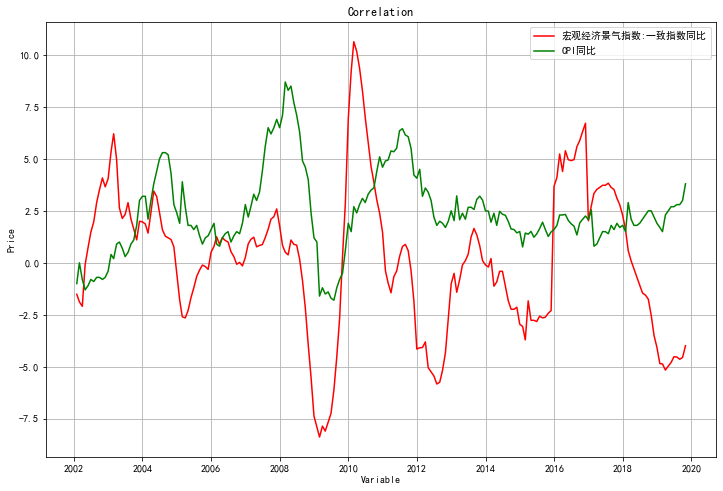

In [9]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
fig=plt.figure(figsize=(12,8))
plt.plot(data["宏观经济景气指数:一致指数同比"],'r',label='宏观经济景气指数:一致指数同比') #直接将数据放进去，加一些参数即可
plt.plot(data["CPI:当月同比"], 'g', label='CPI同比')
plt.title('Correlation')
plt.grid(True)#即是否显示网格线
plt.axis('tight')
plt.legend(loc=0)
plt.ylabel('Price')
plt.xlabel("Variable")
plt.show()

<font size=4 color="08#0000" face="Times new Roman">**ADF Test**</font>

<font size=3 face="宋体"> $\ $  $\ $ $\ $ $\ $ADF检验其实就是单位根检验，如果序列是平稳的，就不存在单位根；否则就会存在单位根；如果存在单位根，自变量和因变量之间的关系就具有欺骗性，因为残差序列的任何误差都不会随着样本量的增大而衰减，也就是说模型中的残差的影响是永久的，这种回归有称为伪回归。如果存在单位根，该过程就是一个随机漫步。<br/>
    $\ $ $\ $ $\ $ $\ $ADF的原假设H0是存在单位根，如果得到显著性验证统计量小于三个置信度（10%，5%，1%），则对应有（90%，95%，99%）的把握来拒绝原假设。</font>

In [18]:
diff1_data=data-data.shift(1)
diff1_data=diff1_data.dropna()
adfResult = sm.tsa.stattools.adfuller(diff1_data["M2:同比"])
output=pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used", 
                           "Critical Value(1%)", "Critical Value(5%)", "Critical Value(10%)"],columns=["value"])
output['value']['Test Statistic Value'] = adfResult[0]
output['value']['p-value']=adfResult[1]
output['value']['Lags Used']=adfResult[2]
output['value']['Number of Observations Used'] = adfResult[3] 
output['value']['Critical Value(1%)'] = adfResult[4]['1%'] 
output['value']['Critical Value(5%)'] = adfResult[4]['5%'] 
output['value']['Critical Value(10%)'] = adfResult[4]['10%']
output#发现又经历一次差分之后变得平稳

,value
Test Statistic Value,-6.51803
p-value,1.05924e-08
Lags Used,11
Number of Observations Used,201
Critical Value(1%),-3.46331
Critical Value(5%),-2.87603
Critical Value(10%),-2.57449


<font size=4 color="08#0000" face="Times New Roman">**协整检验**</font>

In [5]:
result=sm.tsa.stattools.coint(diff1_data["CPI:当月同比"],diff1_data["PPI:当月同比"])
result#返回T值和P值，P值越低代表协整关系越强

(-5.497998053787151,
 1.808758723101282e-05,
 array([-3.94884588, -3.36510304, -3.06451618]))

<font size=4 face="Times New Romman" color="08#0000">**模型估计+定阶** </font>

In [20]:
InDataDict={"CPI同比":diff1_data["CPI:当月同比"],"PPI同比":diff1_data["PPI:当月同比"],"M2同比":diff1_data["M2:同比"]}#选择带入VAR模型的两个变量，建立字典
testdata0 = pd.DataFrame(InDataDict,index=diff1_data.index)
testdata=testdata0[["CPI同比","PPI同比","M2同比"]]
testdata.head()
# InDataDict={"经济一致指数同比一阶差分":diff1_data["宏观经济景气指数:一致指数"],"经济先行指数同比一阶差分":diff1_data["宏观经济景气指数:先行指数"],"工业生产增加值同比一阶差分":diff1_data["工业增加值当月同比"]}#选择带入VAR模型的两个变量，建立字典
# testdata = pd.DataFrame(InDataDict,index=diff1_data.index)
# testdata.head()

,CPI同比,PPI同比,M2同比
日期,,,
2002-02-28,1.0,0.00,-0.1
2002-03-31,-0.8,0.20,1.4
2002-04-30,-0.5,0.94,-0.3
2002-05-31,0.2,0.43,-0.1
2002-06-30,0.3,0.13,0.7


In [ ]:
#[0.4036,-0.5657,0.6075]
[0.1876,-0.2630,0.2824]

In [21]:
#建立对象，dataframe就是前面的data，varLagNum就是你自己定的滞后阶数
orgMod = sm.tsa.VARMAX(testdata,order=(6,0),trend='nc',exog=None)
#估计：就是模型
fitMod = orgMod.fit(maxiter=1000,disp=False)
# 打印统计结果
print(fitMod.summary())

D:\Software Download\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


                               Statespace Model Results                               
Dep. Variable:     ['CPI同比', 'PPI同比', 'M2同比']   No. Observations:                  213
Model:                                 VAR(6)   Log Likelihood                -588.247
Date:                        Sat, 15 Feb 2020   AIC                           1296.493
Time:                                10:57:50   BIC                           1498.171
Sample:                            02-28-2002   HQIC                          1377.998
                                 - 10-31-2019                                         
Covariance Type:                          opg                                         
Ljung-Box (Q):          144.42, 75.14, 49.75   Jarque-Bera (JB):   19.57, 74.76, 21.89
Prob(Q):                    0.00, 0.00, 0.14   Prob(JB):              0.00, 0.00, 0.00
Heteroskedasticity (H):     0.53, 1.08, 0.63   Skew:                 -0.04, 0.43, 0.49
Prob(H) (two-sided):        0.01, 0.75, 0.0

<font size=4 color= "08#0000" face="宋体">**系数平稳性检验：CUSUM检验**</font>

<font size=3 face="宋体"> $\ $ $\ $ $\ $ $\ $Python无法像EVIEWS那样算$AR$根，进而画出$AR$图，但是Python可以进行CUSUM检验，返回3个变量，第二个值是P-value，但是这里需要强调的是CUSUM检验的原假设$H_0$是：系数平稳，备择假设是系数非平稳。**因此只有CUSUM的检验结果无法拒绝原假设才算通过，即$P$值要满足$P>0.05$。**</font >

In [20]:
# 获得模型残差
resid = fitMod.resid  #因为涉及到两个变量，两个回归方程对应两个残差序列
result = {'fitMod':fitMod,'resid':resid} #建立字典，分别保存模型结果和残差序列。
#从函数注释中可以知道需要输入变量的类型，以下函数需要输入的是narray.
resid=np.array(resid)
result = statsmodels.stats.diagnostic.breaks_cusumolsresid(resid)
result#分别对应统计量

(0.9663508397811797, 0.3078280377085388, [(1, 1.63), (5, 1.36), (10, 1.22)])

<font size=4 color="08#0000" face= "宋体"> **脉冲响应图**</font>

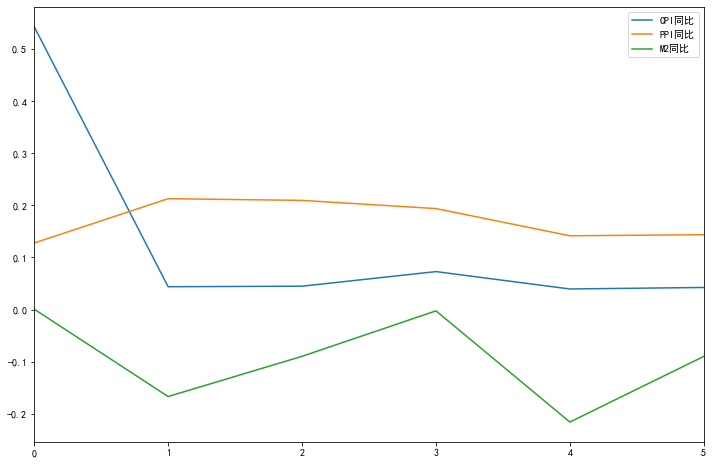

In [63]:
# orthogonalized=True，代表采用乔里斯基正交 
terms=5
ax = fitMod.impulse_responses(terms,orthogonalized=True).plot(figsize=(12, 8))
plt.show()

D:\Software Download\Ananconda\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


FEVD for CPI同比
        CPI同比     PPI同比      M2同比
0    1.000000  0.000000  0.000000
1    0.964283  0.021233  0.014484
2    0.951401  0.026328  0.022270
3    0.947258  0.028210  0.024532
4    0.946547  0.028926  0.024527
5    0.946368  0.029033  0.024599
6    0.946359  0.029044  0.024597
7    0.946359  0.029043  0.024598
8    0.946357  0.029045  0.024598
9    0.946356  0.029046  0.024598

FEVD for PPI同比
        CPI同比     PPI同比      M2同比
0    0.068963  0.931037  0.000000
1    0.137246  0.854844  0.007910
2    0.183423  0.795924  0.020653
3    0.202259  0.771467  0.026274
4    0.208643  0.763357  0.028000
5    0.209875  0.761794  0.028331
6    0.209873  0.761794  0.028334
7    0.209810  0.761859  0.028331
8    0.209815  0.761843  0.028342
9    0.209833  0.761815  0.028352

FEVD for M2同比
        CPI同比     PPI同比      M2同比
0    0.000086  0.000094  0.999820
1    0.053857  0.004191  0.941952
2    0.062535  0.036889  0.900576
3    0.074142  0.056217  0.869642
4    0.079983  0.064406  0.855611
5 

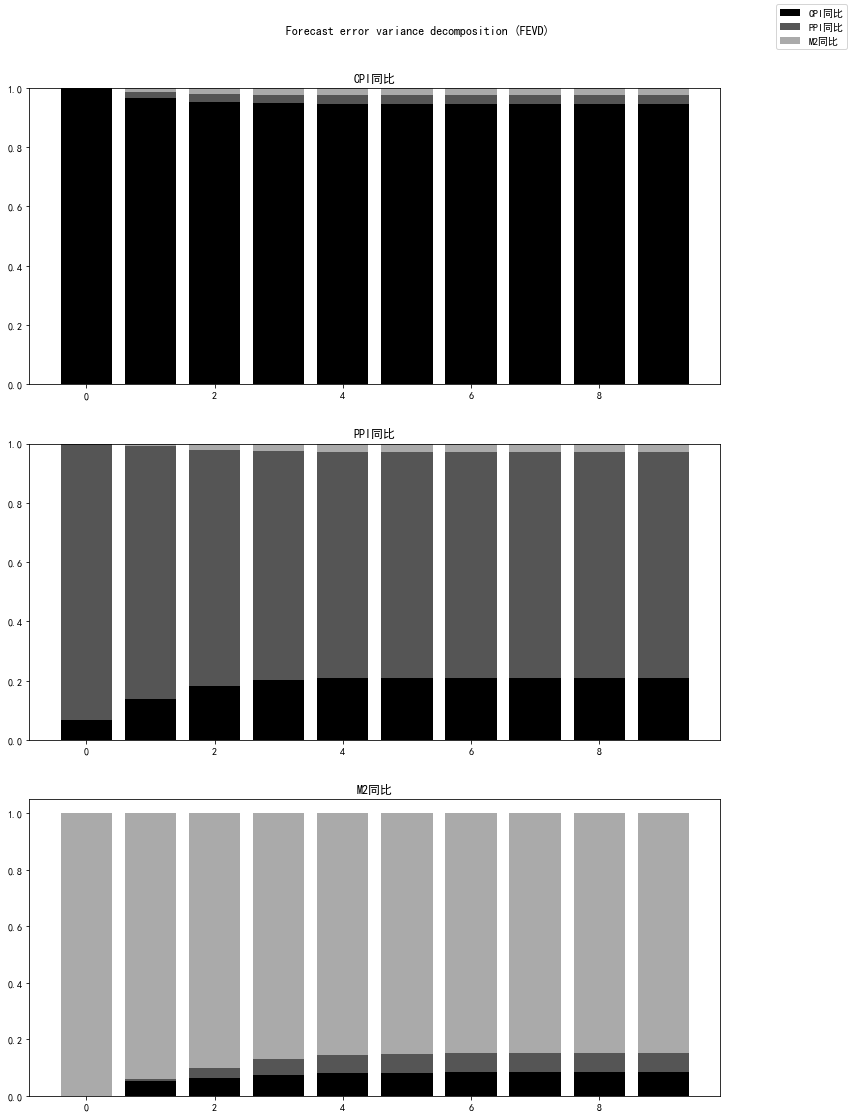

In [64]:
md = sm.tsa.VAR(testdata)
re = md.fit(2)
fevd = re.fevd(10)
# 打印出方差分解的结果
print(fevd.summary())
# 画图
fevd.plot(figsize=(12, 16))
plt.show()